### Objective

**Identify the most profitable zip codes in NYC for our investor client to set-up short-term AirBNB rentals.**


### Key Findings:

Using capitalization rate as a measure of profitability, the top 3 most profitable zipcodes for our client are:

    (1) 10303 (15.3%)
    (2) 11231 (4.124%)
    (3) 11215 (3.25%)
 
Zipcode 10303 in Staten Island should be targeted for investment properties for short-term AirBnB rentals.

### Solution Overview:

    (1) Ingest data
    (2) Assess Data Quality & Clean
    (3) Data Integration
        (a) Project median zip code home sale prices for 2019 using a time series model
        (b) Impute for zip codes with no historical prices
        (c) Estimate individual property prices
        (d) Combine data sets
    (4) Profitability Assessment
    (5) Mapping Recommendations    
    
    
### Next Steps

Next steps should focus on refining the methods used to impute missing data and estimating occupancy rates rather than using the 75% assumption. Additionally, a thorough QA of the codeset is necessary to identify dropped records in the later portion of the analysis.

In [904]:
#Load Relevant Packages
import os #Set directory
import pandas as pd #Data and manipulation
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt #initialize visualization
import statistics #summary statistics functions
import re #regex
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #forecast price
import statsmodels.api as sm
from datetime import datetime #date manipulation
from pmdarima.arima import auto_arima #forecast price
import folium #mapping
import json, requests #interaction with json file in github

In [905]:
os.chdir('C:\\Users\\dmoxley\\downloads') #Client path

In [906]:
df_zillow = pd.read_csv("Zip_Zhvi_2bedroom.csv") #import Zillow historical median price data
df_zillow_norm = pd.melt(df_zillow, id_vars=df_zillow.columns[0:7].tolist(),var_name="date",value_name="median_price") #normalize
df_abnb = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2019-07-08/data/listings.csv.gz")

C:\Users\dmoxley\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [907]:
print('{0} data date range: {1} to {2}'.format('AirBNB', df_abnb["last_scraped"].min(), df_abnb["last_scraped"].max()))
print('{0} data date range: {1} to {2}'.format('Zillow', df_zillow_norm["date"].min(), df_zillow_norm["date"].max()))

AirBNB data date range: 2019-07-08 to 2019-07-09
Zillow data date range: 1996-04 to 2017-06


# Data Quality Check
The objective of the Data Qualtiy Check is to assess the data on measures of (1) completeness and (2) reliability of data type to determine if inadequacies are random or have any correlations that would introduce bias into the analysis.

From this, four issues were addressed.

*(1) 30 fields in the AirBNB data had missing records (blanks or NaNs) while 173 fields (dates) in the Zillow data had missing information.*
 
*(2) Only one field, zipcode, located in the AirBNB file had notable data quality issues with records recorded as a 5 digit zip, 5 digit + 4 zipcode, and just as the +4*

*(3) Numerical values of interest, square_feet, price, weekly_price, and monthly_price, were recorded in the dataset as strings with their currency (USD). These needed to be cleaned as stored as float.*

*(4) Additionally, the data files had inconsistent column heading formats and were renamed using snake casing.*

In [908]:
def udf_profile_data_quality(df,missingness_threshold):
    """
    Takes a source dataframe
    Returns dataframe of the source fields with multiple data types 
        or records in excess of a given proportion of total records
        with blanks or NaN values
    and Returns dictionary summarizing the number of columns 
        with missingness and/or inconsistent datatypes
    """
    
    record_cnt = len(df)
    df_dq=pd.DataFrame(columns=['column_name','na_values', 'blank_values', 'int_values', 'float_values', 'str_values'])

    #evaluate each column
    for column_name in df.columns:
        integer=flts=strings=nas=blank=0 #reset data type counters

        #record if row value is integer, float or string
        for index, value in df.loc[:,column_name].items():

            if pd.isna(value):
                nas+=1
            elif isinstance(value, str) and value.strip()=="":
                blank+=1
            elif isinstance(value, int):
                integer+=1
            elif isinstance(value, float):
                flts+=1
            elif isinstance(value, str):
                strings+=1


        #update dictionary with column and data type counts 
        #if more than 1 data type is identified at a rate exceeding user-defined threshold
        if (blank>(record_cnt*missingness_threshold) and blank<record_cnt) | (nas>(record_cnt*missingness_threshold) and nas<record_cnt) | (integer>0 and integer<(record_cnt*(1-missingness_threshold))) | (flts>0 and flts<(record_cnt*(1-missingness_threshold))) | (strings>0 and strings<(record_cnt*(1-missingness_threshold))):
            df_dq=df_dq.append({'column_name':column_name
                                ,'na_values':nas
                                ,'blank_values':blank
                                ,'int_values':integer
                                ,'float_values':flts
                                ,'str_values':strings}
                               , ignore_index=True)
    
    #initialize dictionary summarizing data quality issues
    dq_issues={'NAs':len(df_dq[df_dq['na_values']>0])
               ,'Blanks':len(df_dq[df_dq['blank_values']>0])
               ,'Ints & Strings':len(df_dq[(df_dq['int_values']>0)&(df_dq['str_values']>0)])
               ,'Floats & Strings':len(df_dq[(df_dq['float_values']>0)&(df_dq['str_values']>0)])}

    return df_dq,dq_issues

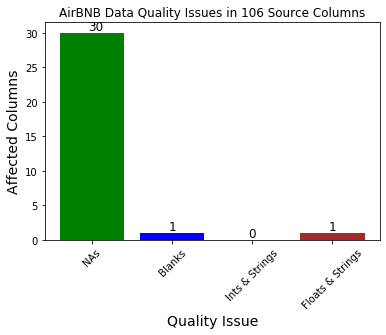

In [909]:
#Evaluate AirBNB data quality using 2% threshold
df_data_quality_abnb,summary_data_quality = udf_profile_data_quality(df_abnb,.02)
data_quality_metrics=summary_data_quality.keys()
data_quality_values=summary_data_quality.values()

#Visualize
label_colors = ['green','blue','red','brown']

plt.xticks(range(len(data_quality_values)), data_quality_metrics)
plt.xlabel('Quality Issue', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Affected Columns', fontsize=14)
plt.title('AirBNB Data Quality Issues in '+str(len(df_abnb.columns))+' Source Columns')
plt.bar(range(len(data_quality_values)), data_quality_values, color=label_colors)
##Add labels
for index,data in enumerate(data_quality_values):
    plt.text(x=index-.05 , y =data+.4, s=f"{data}" , fontdict=dict(fontsize=12))
plt.show()

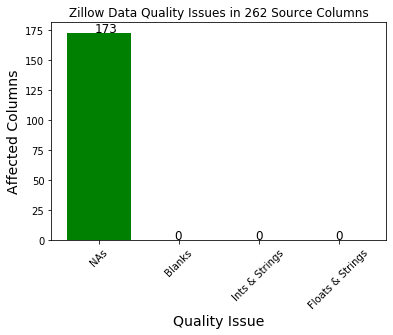

In [910]:
#Evaluate Zillow data quality using 2% threshold
df_data_quality_zillow,summary_data_quality=udf_profile_data_quality(df_zillow,.02)
data_quality_metrics=summary_data_quality.keys()
data_quality_values=summary_data_quality.values()

#visualize
label_colors = ['green','blue','red','brown']

plt.xticks(range(len(data_quality_values)), data_quality_metrics)
plt.xlabel('Quality Issue', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Affected Columns', fontsize=14)
plt.title('Zillow Data Quality Issues in '+str(len(df_zillow.columns))+' Source Columns')
plt.bar(range(len(data_quality_values)), data_quality_values, color=label_colors)
##Add labels
for index,data in enumerate(data_quality_values):
    plt.text(x=index-.05 , y =data+.4, s=f"{data}" , fontdict=dict(fontsize=12))
plt.show()

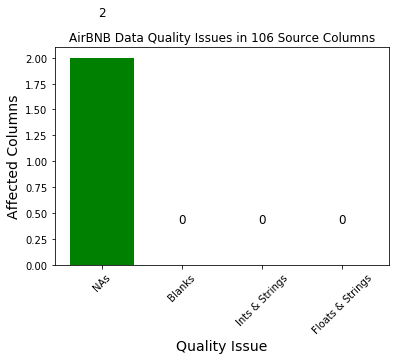

In [911]:
#Evaluate Zillow Normalized dataframe data quality using 2% threshold
df_data_quality_zillow_norm,summary_data_quality = udf_profile_data_quality(df_zillow_norm,.02)
data_quality_metrics = summary_data_quality.keys()
data_quality_values = summary_data_quality.values()

#Visualize
label_colors = ['green','blue','red','brown']

plt.xticks(range(len(data_quality_values)), data_quality_metrics)
plt.xlabel('Quality Issue', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Affected Columns', fontsize=14)
plt.title('AirBNB Data Quality Issues in '+str(len(df_abnb.columns))+' Source Columns')
plt.bar(range(len(data_quality_values)), data_quality_values, color=label_colors)
##Add labels
for index,data in enumerate(data_quality_values):
    plt.text(x=index-.05 , y =data+.4, s=f"{data}" , fontdict=dict(fontsize=12))
plt.show()

del summary_data_quality, data_quality_metrics, data_quality_values

# Data Quality Remediation
**AirBNB - NAs**

    Fields with greater numbers NA and blank records are largely attributes of business keys such as rental description details and reviews. Since a description is either available or not, these could be recoded as dummy variables later in the analysis.


In [912]:
#AirBNB NAs
df_abnb[df_data_quality_abnb.loc[(df_data_quality_abnb['na_values']>0)|(df_data_quality_abnb['blank_values']>0),"column_name"]].drop_duplicates().head(25)

,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_about,host_response_time,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,reviews_per_month
0,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,Educated professional living in Brooklyn. I l...,within an hour,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,0.21
1,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...",Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",A New Yorker since 2000! My passion is creatin...,within a few hours,...,95.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,0.38
2,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,Make Up Artist National/ (Website hidden by Ai...,within a day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,Laid-back bi-coastal actor/professor/attorney.,within a few hours,...,90.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,4.64
4,NaN,Loft apartment with high ceiling and wood floo...,NaN,NaN,NaN,NaN,NaN,Please be considerate when staying in the apar...,I have been a NYer for almost 10 years. I came...,NaN,...,93.0,10.0,9.0,10.0,10.0,9.0,10.0,NaN,NaN,0.10
5,My large 1 bedroom apartment is true New York ...,I have a large 1 bedroom apartment centrally l...,My neighborhood in Midtown East is called Murr...,Read My Full Listing For All Information. New ...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,I usually check in with guests via text or ema...,• Check-in time is 2PM. • Check-out time is 12...,"I'm an artist, writer, traveler, and a native ...",within an hour,...,89.0,10.0,9.0,10.0,10.0,9.0,9.0,NaN,NaN,0.59
6,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,NaN,NaN,NaN,NaN,NaN,NaN,"I am an artist(painter, filmmaker) and curato...",NaN,...,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NaN,NaN,0.40
7,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...","Theater district, many restaurants around here.",Reservation should be made at least a few days...,NaN,Bathroom is shared with the host but the kitch...,NaN,"No smoking in the room. When you check out, pl...",I used to work for a financial industry but no...,within a few hours,...,84.0,9.0,7.0,10.0,9.0,10.0,9.0,NaN,NaN,3.47
8,"Our best guests are seeking a safe, clean, spa...",Stay in my family's little guest room and enj...,Our neighborhood is full of restaurants and ca...,"Because we are an active family, I guarantee t...",The number 1 train stops at 110th Street/Cathe...,Guests will be able to come and go as they nee...,My modern family is super busy with lots of co...,"No smoking. In fact, there is no smoking anywh...",Welcome to family life with my oldest two away...,NaN,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,0.99
9,"Live like a New Yorker instead of a stuffy, ti...",PLEASE NOTE: do not automatically book with ou...,"Historically, the Lower East Side was a stoppi...",This is my personal apartment. It's not a busi...,"F train, Eas

**AirBNB - Data Type Reliability**

    Zipcode has NaNs, Zip+4, and errant values of just the +4. Will Conform to 5 digit zip code and drop other records

In [913]:
df_abnb[df_data_quality_abnb.loc[(df_data_quality_abnb['float_values']>0)&(df_data_quality_abnb['str_values']>0),'column_name']].drop_duplicates().head(10)

,zipcode
0,11218
1,10018
2,10027
3,11238
4,10029
5,10016
6,11216
7,10019
8,10025
9,10002


In [914]:
#remediate 'Zipcode'
df_abnb['zipcode']=df_abnb['zipcode'].str[:5] #limit to 5 digit zip code
bgn_rec_count = len(df_abnb)
df_abnb = df_abnb[df_abnb['zipcode'].str.len()==5]
print(bgn_rec_count-len(df_abnb),"records removed due to missingness or errant entry")

16512 records removed due to missingness or errant entry


**Zillow - NAs**

    The column Metro has NA values worth investigating, the other NA values reflect lack of history for specific zip codes. In the target geography of NYC, the data have a minimum of 7 years of history

In [915]:
df_zillow.loc[(df_zillow['City']=='New York') & (df_zillow['State']=='NY') & (df_zillow['Metro']=='New York'),df_data_quality_zillow.loc[(df_data_quality_zillow['na_values']>0)|(df_data_quality_zillow['blank_values']>0),"column_name"]].head(10)

,Metro,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07
0,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,828800.0,821400.0,813900.0,813300.0,821500.0,831700.0,845100.0,854500.0,858900.0,859200.0
2,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1331800.0,1334800.0,1314200.0,1271900.0,1252300.0,1262300.0,1279200.0,1309000.0,1335300.0,1353800.0
13,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,957500.0,959300.0,969400.0,985400.0,983700.0,983400.0,1007600.0,1023000.0,1010500.0,1006800.0
14,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1432100.0,1422700.0,1402200.0,1378600.0,1372300.0,1393100.0,1430000.0,1462100.0,1476800.0,1479000.0
20,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1299700.0,1296500.0,1273900.0,1227800.0,1202600.0,1207100.0,1220100.0,1252400.0,1285700.0,1278300.0
31,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,704600.0,723000.0,736600.0,742800.0,747500.0,750300.0,753800.0,758900.0,764600.0,767300.0
51,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,364000.0,364300.0,369700.0,378700.0,386600.0,391600.0,392900.0,392900.0,393800.0,392800.0
67,New York,123100.0,124000.0,123900.0,123300.0,122900.0,122600.0,122000.0,121300.0,120600.0,...,280500.0,280500.0,284000.0,288700.0,290800.0,290200.0,289200.0,287000.0,286000.0,286800.0
70,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,504500.0,499300.0,507700.0,529300.0,544800.0,540900.0,538300.0,536800.0,539400.0,546600.0
108,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1154400.0,1164400.0,1160400.0,1126000.0,1107300.0,1116100.0,1138500.0,1175900.0,1199700.0,1198700.0


# Data Cleaning

**(1) Standardize to snake_case naming convention**

**(2) Add national median prices to Zillow file, normalize dataframe**

**(3) Conform data types**
    
    (i) Ensure dates are dates
    (ii) square_feet, price, weekly_price, monthly_price, minimum_nights, maximum_nights, and 
    availability_30(60,90,365) should be numerical (float or integers)


In [916]:
def udf_standardize_naming_conventions(df):
    """
    standardize column names from Camel Case to snake case

    Takes a source dataframe
    Returns dataframe with columns written as snake_case
    
    Credit for succinct regex solution: https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case
    """
    new_column_names={}
    for col in df.columns:
        new_column_names.update({col:re.sub('(?!^)([A-Z]+)', r'_\1',col).lower()}) #(?!^) look back found on stackedoverflow as solution for leading underscore
    
    df = df.rename(columns=new_column_names)

    return df

In [917]:
# snake_case!
df_zillow = udf_standardize_naming_conventions(df_zillow)

In [918]:
# normalize
df_zillow_norm = pd.melt(df_zillow, id_vars=df_zillow.columns[0:7].tolist(),var_name="date",value_name="median_price") #normalize

In [919]:
# conform dates to datetime
df_zillow_norm['date'] = pd.to_datetime(df_zillow_norm['date']+'-01', format='%Y-%m-%d') 

In [920]:
# conform to float or integer data types
df_abnb.loc[:,['square_feet', 'price', 'weekly_price', 'monthly_price', 'minimum_nights', 'maximum_nights'
          , 'availability_30', 'availability_60', 'availability_90', 'availability_365']].dtypes

square_feet         float64
price                object
weekly_price         object
monthly_price        object
minimum_nights        int64
maximum_nights        int64
availability_30       int64
availability_60       int64
availability_90       int64
availability_365      int64
dtype: object

In [921]:
#Price
print(df_abnb['price'].head(15))
df_abnb['price'] = df_abnb['price'].str.replace("$","")
df_abnb['price'] = df_abnb['price'].str.replace(",","").astype(float)

0     $149.00
1     $225.00
2     $150.00
3      $89.00
4      $80.00
5     $200.00
6      $60.00
7      $79.00
8      $79.00
9     $150.00
10    $135.00
11     $85.00
12     $89.00
13     $85.00
14    $120.00
Name: price, dtype: object


In [922]:
#weekly_price
print(df_abnb['weekly_price'].head(15))
df_abnb['weekly_price'] = df_abnb['weekly_price'].str.replace("$","")
df_abnb['weekly_price'] = df_abnb['weekly_price'].str.replace(",","").astype(float)

0       $299.00
1     $1,995.00
2           NaN
3       $575.00
4       $600.00
5           NaN
6           NaN
7       $470.00
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
Name: weekly_price, dtype: object


In [923]:
#monthly_price
print(df_abnb['monthly_price'].head(15))
df_abnb['monthly_price'] = df_abnb['monthly_price'].str.replace("$","")
df_abnb['monthly_price'] = df_abnb['monthly_price'].str.replace(",","").astype(float)

0       $999.00
1           NaN
2           NaN
3     $2,100.00
4     $1,600.00
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10    $2,800.00
11          NaN
12          NaN
13          NaN
14    $3,600.00
Name: monthly_price, dtype: object


**Zillow Median Price Outliers**

According to the Case-Shiller House Price Index (https://fred.stlouisfed.org/series/CSUSHPINSA), an index of single-family home prices in the U.S. normalized to a value of 100 in the year 2000, home prices during the time period of our dataset, April 1996 to June 2017, have ranged from a low of 82.1 (04/1996) to a high of 192.3 (June 2017). Ideally, we could look at year-over-year changes within this pricing index as a way of determining outliers within our own sample based on their variance.

*As a stopgap solution, I'll look at the month-over-month change in median price and replace any median_price_percent_change values in a given region_id with an absolute value of their z score greater than 3 with the most recent proceeding valid observation. I'll then recalculate the median_price using this change*

In [924]:
#calculate previous month median_price and percent change from previous month
df_zillow_norm['median_price_prev_mo'] = df_zillow_norm.sort_values(by=['date'], ascending=True).groupby(['region_id'])['median_price'].shift(1)
df_zillow_norm['median_price_percent_change'] = (df_zillow_norm['median_price'] - df_zillow_norm['median_price_prev_mo'])/df_zillow_norm['median_price_prev_mo']

# calc region mean and standard deviation of monthly median price percent change
df_zillow_norm = pd.merge(df_zillow_norm,df_zillow_norm.groupby('region_id')['median_price_percent_change'].mean().reset_index().rename(columns={"median_price_percent_change":"avg_median_price_percent_change"}))
df_zillow_norm = pd.merge(df_zillow_norm,df_zillow_norm.groupby('region_id')['median_price_percent_change'].std(ddof=1).reset_index().rename(columns={"median_price_percent_change":"std_median_price_percent_change"}))#not assuming normality

# calc absolute value of z-score
df_zillow_norm['z_abs'] = abs((df_zillow_norm['median_price_percent_change']-df_zillow_norm['avg_median_price_percent_change'])
                              /df_zillow_norm['std_median_price_percent_change'])

# median price out observations with an outlier median_price_percent_change using mean of non-outliers
z_threshold=3
df_zillow_norm.loc[(df_zillow_norm['z_abs']>z_threshold), 'median_price'] = round(df_zillow_norm.loc[(df_zillow_norm['z_abs']>z_threshold), 'median_price_prev_mo']*(1+np.nanmean(df_zillow_norm.loc[df_zillow_norm['z_abs']<=z_threshold,'median_price_percent_change'])),2)

# reset df to descriptors and median_price
df_zillow_norm=df_zillow_norm.loc[:,["region_id","region_name","city","state","metro","county_name","size_rank","date","median_price","median_price_prev_mo","median_price_percent_change"]]

In [925]:
# calculate national median_price for all dates currently reported
df_national = pd.DataFrame({'region_id':[0], 'region_name':['US'], 'city':[np.NaN], 'state':[np.NaN], 'metro':['National'], 'county_name':[np.NaN], 'size_rank':[0]})
df_national = df_national.append([df_national]*(len(df_zillow_norm['date'].drop_duplicates())-1),ignore_index=True)
df_national = pd.concat([df_national,df_zillow_norm.groupby('date')['median_price'].median(skipna=True).reset_index()],axis=1,sort=False)
df_national = pd.merge(df_national,df_zillow_norm.groupby('date')['median_price_prev_mo'].median(skipna=True).reset_index())
df_national['median_price_percent_change'] = (df_national['median_price'] - df_national['median_price_prev_mo'])/df_national['median_price_prev_mo']
df_zillow_norm = df_zillow_norm.append(df_national)

# Time Series forecast of Median Price

**Key Takeaway**

A time series model was constructed to forecast current (2019) prices for homes in the NYC zipcodes.


**Technical Note**

Zillow data is a panel dataset with historical median price data ending in July 2017. By contrast, the crossectional data available from AirBNB is for 2 days in July 2019
   
*For the sake of time, a univariate time series forecast was selected using a stepwise method. A cursory review of the data (below) shows the series is non-stationary. No significant efforts were made to transform the series to make it stationary. The resulting associations are spurious and thus not suitable for forecasting in reality.*

In [926]:
# set index to datetime
df_zillow_norm.index = df_zillow_norm['date']

In [927]:
# create time series of national median prices
ts_zillow = df_zillow_norm.loc[df_zillow_norm['region_id']==0,'median_price']

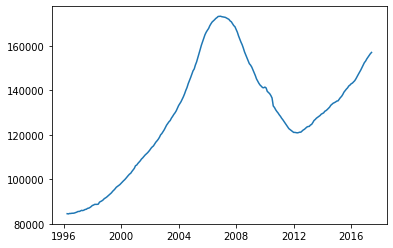

In [928]:
# plot data
plt.plot(ts_zillow)

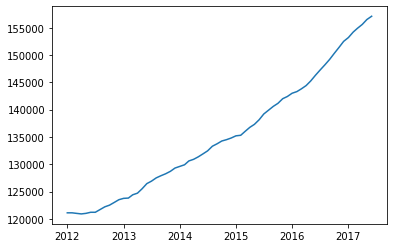

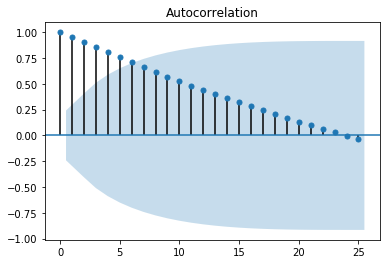

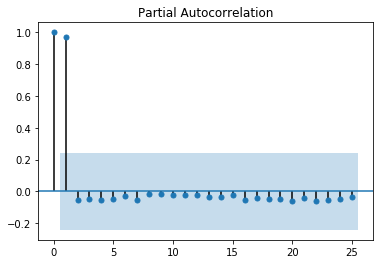

Trend is apparent in the plot of the time series.  Additionally, ACF values are slow to decline and the PACF value at lag 1 is equal to 1. These indicate the series is likely non-stationary. 

Results of Dickey-Fuller Test:

 test statistic     2.542961
p-value            0.999062
lags               4.000000
observations      61.000000
dtype: float64 

 p-value above alpha of .05, failure to reject NULL, process is non-stationary.


In [929]:
ts_zillow = ts_zillow['2012-01-01':] #subset to 2012 or later
# Check for stationarity visually (ACF and PACF) and by Augmented Dickey Fuller test
plt.plot(ts_zillow)
plot_acf(ts_zillow, lags=25)
plot_pacf(ts_zillow, lags=25)
plt.show()
print('Trend is apparent in the plot of the time series. '
      ,'Additionally, ACF values are slow to decline and the PACF value at lag 1 is equal to 1.'
      ,'These indicate the series is likely non-stationary.'
     ,'\n\n\033[1mResults of Dickey-Fuller Test:\033[0m\n\n',pd.Series(stattools.adfuller(ts_zillow.dropna(), autolag='AIC')[0:4], index=['test statistic','p-value','lags','observations'])
      ,'\n\n p-value above alpha of .05, failure to reject NULL, process is non-stationary.')

In [930]:
# Forecasting for demonstration purposes
arima_sw = auto_arima(ts_zillow.dropna()
                      , start_p=1, start_q=1
                      , max_p=6, max_q=6
                      , m=0, seasonal=False #non-seasonal offers similar AIC values, is faster and simpler
                      , d=1
                      , trace=True #print each step's result
                      , error_action='ignore'
                      , suppress_warnings=True
                      , stepwise=True)
print(arima_sw.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=924.203, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=932.209, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=933.862, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=933.947, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1024.899, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=932.406, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=933.224, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=934.755, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=934.744, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.461 seconds
924.2032511210991


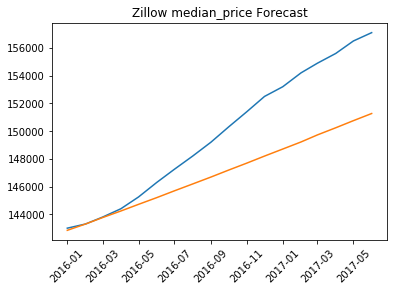

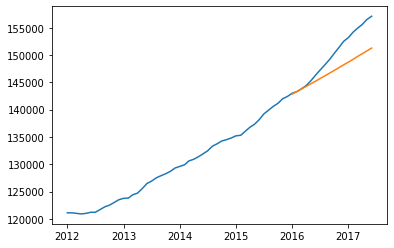

In [931]:
# Predict 18 months from 1-1-2016 to evaluate fit
train = ts_zillow.loc[:'2015-12-01']
test = ts_zillow.loc['2016-01-01':]
arima_sw.fit(train)
future_forecast = arima_sw.predict(n_periods=18)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['forecast'])
plt.plot(pd.concat([test,future_forecast],axis=1))
plt.xticks(rotation=45)
plt.title('Zillow median_price Forecast')

plt.show()
plt.plot(pd.concat([ts_zillow,future_forecast],axis=1))
plt.show()

# Integrate AirBNB and Zillow Data

**(1) Predict prices for NYC zipcodes in both Zillow and AirBNB data using a univariate time series model of median_price**

**(2) Impute sale prices for NYC zip codes not present in the Zillow file**

In [932]:
# Forecasting for demonstration purposes
def udf_predict_ts(ts,prediction_date,visual):
    """
    standardize column names from Camel Case to snake case

    Takes a timeseries (df with date as index), prediction_date, and (1/0) indicator to provide visual of forecast
    Returns given forecast for specified prediction_date using auto_arima

    """
    # estimate coefs
    arima_sw = auto_arima(ts.dropna()
                          , start_p=1, start_q=1
                          , max_p=6, max_q=6
                          , m=0, seasonal=False #non-seasonal offers similar AIC values, is faster and simpler
                          , d=1
                          , trace=False #print each step's result
                          , error_action='ignore'
                          , suppress_warnings=True
                          , stepwise=True)

    arima_sw.fit(ts)# fit model
    
    # define prediction interval in months
    forecast_range = pd.date_range(max(ts.index),prediction_date, freq='MS').strftime("%Y-%m-%d").tolist()
    forecast_length = len(forecast_range)

    # forecast
    future_forecast = arima_sw.predict(n_periods=forecast_length)
    forecast = future_forecast[forecast_length-1]
    if visual==1:
        future_forecast = pd.DataFrame(future_forecast,index = forecast_range,columns=['forecast'])
        plt.plot(pd.concat([ts,future_forecast],axis=1))
        
    return forecast

In [933]:
# limit to NYC zipcodes and forecast median_sale_price
df_zillow_norm = df_zillow_norm[(df_zillow_norm['state']=='NY')&(df_zillow_norm['city']=='New York')]
df_abnb = df_abnb[(df_abnb['state']=='NY')&(df_abnb['city']=='New York')]

for z in df_abnb['zipcode'].drop_duplicates():
    ts = df_zillow_norm.loc[df_zillow_norm['region_name'].astype(int)==int(z),'median_price']
    
    if len(ts)!=0:
        df_abnb.loc[df_abnb['zipcode'].astype(int)==int(z),'median_sale_price'] = udf_predict_ts(ts,'2019-07-01',0)

**Impute Missing Prices**

Missing median sale prices were replaced with a prediction made using a linear regression.


**Technical Note:**
Many additional considerations should be made. Most notably, sample size and multicolinearity between chosen covariates will lead to inconsistent estimates.

In [934]:
# Calculate mean values by zipcode for square_feet, bathrooms, bedrooms
df_abnb = pd.merge(df_abnb,pd.DataFrame(df_abnb.groupby('zipcode')['square_feet'].agg(np.mean)).reset_index().rename(columns={'square_feet':'mean_sq_ft'}))
df_abnb = pd.merge(df_abnb,pd.DataFrame(df_abnb.groupby('zipcode')['bathrooms'].agg(np.mean)).reset_index().rename(columns={'bathrooms':'mean_bthrms'}))
df_abnb = pd.merge(df_abnb,pd.DataFrame(df_abnb.groupby('zipcode')['bedrooms'].agg(np.mean)).reset_index().rename(columns={'bedrooms':'mean_bdrms'}))

#replace zipcodes with missing values with median values
df_abnb.loc[(np.isnan(df_abnb['mean_sq_ft'])==True) | (df_abnb['mean_sq_ft']==0),'mean_sq_ft'] = df_abnb.loc[(np.isnan(df_abnb['mean_sq_ft'])==False) & (df_abnb['mean_sq_ft']!=0),'mean_sq_ft'].median()
df_abnb.loc[(np.isnan(df_abnb['mean_bthrms'])==True) | (df_abnb['mean_bthrms']==0),'mean_bthrms'] = df_abnb.loc[(np.isnan(df_abnb['mean_bthrms'])==False) & (df_abnb['mean_bthrms']!=0),'mean_bthrms'].median()
df_abnb.loc[(np.isnan(df_abnb['mean_bdrms'])==True) | (df_abnb['mean_bdrms']==0),'mean_bdrms'] = df_abnb.loc[(np.isnan(df_abnb['mean_bdrms'])==False) & (df_abnb['mean_bdrms']!=0),'mean_bdrms'].median()

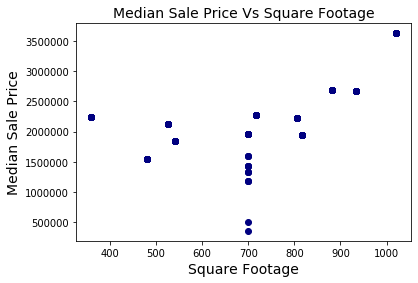

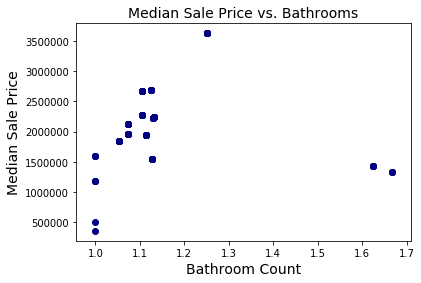

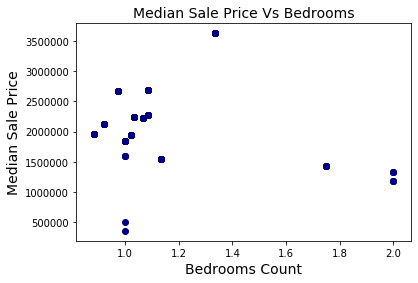

In [935]:
# Visualize relationships with median_sale_price
# MSP vs Square Footage
plt.scatter(train_price['mean_sq_ft'], train_price['median_sale_price'], color='navy')
plt.title('Median Sale Price Vs Square Footage', fontsize=14)
plt.xlabel('Square Footage', fontsize=14)
plt.ylabel('Median Sale Price', fontsize=14)
plt.show()

# MSP vs Bathroom count
plt.scatter(train_price['mean_bthrms'], train_price['median_sale_price'], color='navy')
plt.title('Median Sale Price vs. Bathrooms', fontsize=14)
plt.xlabel('Bathroom Count', fontsize=14)
plt.ylabel('Median Sale Price', fontsize=14)
plt.show()

# MSP vs Bedroom Count
plt.scatter(train_price['mean_bdrms'], train_price['median_sale_price'], color='navy')
plt.title('Median Sale Price Vs Bedrooms', fontsize=14)
plt.xlabel('Bedrooms Count', fontsize=14)
plt.ylabel('Median Sale Price', fontsize=14)
plt.show()

In [936]:
train_price = df_abnb.loc[np.isnan(df_abnb['median_sale_price'])==False,['zipcode','mean_bdrms','mean_bthrms','mean_sq_ft','median_sale_price']]
impute_price = df_abnb.loc[np.isnan(df_abnb['median_sale_price'])==True,['zipcode','mean_bdrms','mean_bthrms','mean_sq_ft','median_sale_price']]

# Predict median_sale_price where missing
iv = train_price[['mean_bdrms','mean_bthrms','mean_sq_ft']]
dv = train_price['median_sale_price']

iv = sm.add_constant(iv)
lm_ols = sm.OLS(dv, iv).fit()
predictions = lm_ols.predict(iv) 
 
print(lm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:      median_sale_price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3464.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:45:38   Log-Likelihood:                -69936.
No. Observations:                4993   AIC:                         1.399e+05
Df Residuals:                    4989   BIC:                         1.399e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.719e+06   1.25e+05    -29.755      

C:\Users\dmoxley\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [937]:
# impute prices
iv = impute_price[['mean_bdrms','mean_bthrms','mean_sq_ft']]
iv = sm.add_constant(iv)
predictions = lm_ols.predict(iv) 
impute_price = pd.concat([impute_price.iloc[:,0:3],pd.DataFrame({'median_sale_price':predictions})],axis=1)

C:\Users\dmoxley\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [939]:
# add imputed prices to records missing a price
df_abnb_incomplete = df_abnb[np.isnan(df_abnb['median_sale_price'])==True]
df_abnb_complete = df_abnb[np.isnan(df_abnb['median_sale_price'])==False]

In [948]:
prices = train_price.append(impute_price)
prices = prices[['zipcode','median_sale_price']].drop_duplicates()
#len(prices.drop_duplicates())
#len(df_abnb['zipcode'].drop_duplicates())

In [984]:
# inelegantly combine everything again
df_abnb=df_abnb.drop(['median_sale_price'], axis=1)
df_abnb_incomplete = pd.merge(df_abnb,prices.drop_duplicates(),right_on='zipcode',left_on='zipcode')
df_abnb_incomplete=df_abnb_incomplete[df_abnb_complete.columns] #reorder columns

df_abnb = df_abnb_incomplete.append(df_abnb_complete)

**Determine individual property values**

With our given assumption
    
    "All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)"
    
I will set prices based on their ratio to the mean for their locale (zipcode).

(array([6.000e+00, 1.700e+01, 2.088e+03, 2.551e+03, 8.000e+00, 3.150e+02,
        6.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([4.76418317e+03, 7.15133122e+05, 1.42550206e+06, 2.13587100e+06,
        2.84623994e+06, 3.55660888e+06, 4.26697782e+06, 4.97734675e+06,
        5.68771569e+06, 6.39808463e+06, 7.10845357e+06]),
 <a list of 10 Patch objects>)

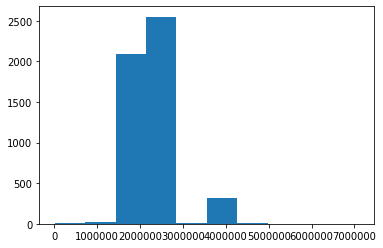

In [985]:
# Lastly, estimate individual property values as a function of their standard deviation in square footage
df_abnb.loc[(np.isnan(df_abnb['square_feet'])==True) | (df_abnb['square_feet']==0),'square_feet'] = df_abnb.loc[(np.isnan(df_abnb['square_feet'])==True) | (df_abnb['square_feet']==0) ,'mean_sq_ft']
df_abnb['sale_price'] = df_abnb['median_sale_price']*df_abnb['square_feet']/df_abnb['mean_sq_ft']

plt.hist(df_abnb['sale_price'])

# Calculate Profitability

We'll look at a capitalization rate as a measure of a property's profitability.

    Net operating income/value

Assumptions:
    
    -Expenses are ignored (taxes, maintenance, etc)
    -Occupancy rate is 75%


In [986]:
df_abnb['annual_income'] = 365.25*.75*df_abnb['price'] #75% of the time it is rented at the short term rate

In [987]:
df_abnb['cap'] = df_abnb['annual_income']/df_abnb['sale_price']*100

(array([4.971e+03, 1.500e+01, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,  34.49961809,  68.99923617, 103.49885426,
        137.99847235, 172.49809043, 206.99770852, 241.49732661,
        275.99694469, 310.49656278, 344.99618086]),
 <a list of 10 Patch objects>)

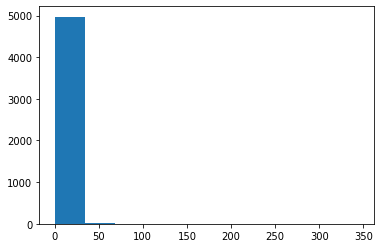

In [988]:
# review distribution of cap rates
plt.hist(df_abnb['cap'])

In [989]:
df_abnb = pd.merge(df_abnb,pd.DataFrame(df_abnb.groupby('zipcode')['cap'].agg(np.mean)).reset_index().rename(columns={'cap':'mean_cap'}))
df_abnb = pd.merge(df_abnb,pd.DataFrame(df_abnb.groupby('zipcode')['cap'].median(skipna=True)).reset_index().rename(columns={'cap':'median_cap'}))


In [991]:
nyc_profit_by_zip = df_abnb[['zipcode','median_cap']].sort_values(by='median_cap',ascending=False).drop_duplicates()
nyc_profit_by_zip.head(5)

,zipcode,median_cap
4992,10303,15.340121
4980,11231,4.123905
4991,11215,3.250184
917,10036,2.424648
3178,10023,2.182337
